In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
root_path = '/content/gdrive/My Drive/TGS-Salt-Segmentation/'
sys.path.append(root_path)

In [0]:
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K

import tensorflow as tf


import imgaug as ia
from imgaug import augmenters as iaa

from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

import numpy as np

# Define augmentation sequence

In [0]:
# sometimes = lambda aug: iaa.Sometimes(0.5, aug)
"""
augment 50% of the time images: flip left right || affine || crop and pad

"""
aug_sequence = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.OneOf([
        iaa.Noop(), #no operation
        iaa.Affine(rotate=(-10, 10), translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0), backend="cv2"),
        iaa.Noop(),
        iaa.CropAndPad(
            percent=(-0.2, 0.2),
            pad_mode="reflect",
            pad_cval=0,
            keep_size=False
        ),
    ])
])



def augment(x_train, y_train):
    """
    x_train and y_train will be single images of size (h, w, 1)
    returns the given images augmented
    """
    seq_det = aug_sequence.to_deterministic()
    
    x_train_aug = seq_det.augment_image(x_train)
    y_train_aug = seq_det.augment_image(y_train)
    
    if y_train_aug.shape != x_train.shape or x_train_aug.shape != x_train.shape:
        x_train_aug = ia.imresize_single_image(x_train_aug, x_train.shape[:2], interpolation="linear")
        y_train_aug = ia.imresize_single_image(y_train_aug, x_train.shape[:2], interpolation="nearest")
    return np.array(x_train_aug), np.array(y_train_aug)


aug shapes (128, 128, 1) (128, 128, 1)


# Define image generator with augmentation

In [0]:
# data generator from given images
def image_generator(x_train, y_train, batch_size=32):
    all_batches_index = np.arange(0, x_train.shape[0])
    
    #lists to store augmented images, these lists reprezent the batches
    out_images = [] 
    out_masks = []
    
    while True:
        np.random.shuffle(all_batches_index)
        for index in all_batches_index:
            img, mask = augment(x_train[index], y_train[index])
#             img, mask = x_train[index], y_train[index]
       
            out_images.append(img)
            out_masks.append(mask)
            if len(out_images) >= batch_size:
                yield np.stack(out_images, axis=0), np.stack(out_masks, 0)
#                 yield out_images, out_masks
#                 count_idx = 0
                out_images, out_masks = [], []

In [0]:
max=10
for i, m in image_generator(x_train, y_train):
  if max == 0:
    break
  print(i.shape, m.shape)
  max -=1

# Define Paths and load data

In [0]:
img_size = 128
train_img_path = root_path + 'data/{}/all_samples/'.format(img_size)

x_train_path = train_img_path + 'x_train.npy'
y_train_path = train_img_path + 'y_train.npy'
x_valid_path = train_img_path + 'x_valid.npy'
y_valid_path = train_img_path + 'y_valid.npy'

# train_img_ids = np.load(train_img_path + 'ids_train.npy', allow_pickle=True)

x_train = np.load(x_train_path, allow_pickle=True)
y_train = np.load(y_train_path, allow_pickle=True)
x_valid = np.load(x_valid_path, allow_pickle=True)
y_valid = np.load(y_valid_path, allow_pickle=True)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(3200, 128, 128, 1)
(3200, 128, 128, 1)
(800, 128, 128, 1)
(800, 128, 128, 1)


In [0]:
def iou(y_true, y_pred):
    import numpy as np     # linear algebra library
    import pandas as pd    
    import tensorflow as tf
    from random import randint
    from keras import backend as K
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
""" Model paths to train"""

model_path = '/content/gdrive/My Drive/TGS-Salt-Segmentation/models/trained/unet_vanilla_128_adam_binary-crossentropy_iou-metric-64.h5'
model_name = model_path.split('/')[-1][:-3]
model_history_loss_path = root_path + 'models/history/' + model_name + '-loss.png'
model_history_score_path = root_path + 'models/history/' + model_name + '-score.png'
model_trained_path = '/content/gdrive/My Drive/TGS-Salt-Segmentation/models/trained/'+model_path.split('/')[-1]


""" model hyperparameters """
batch_size=32
epochs = 1000
model = load_model(model_path, custom_objects={'iou':iou})
train_generator = image_generator(x_train, y_train, batch_size=batch_size)

if 'accuracy' in model_path:
  monitor='val_acc'
  monitor_mode = 'max'
elif 'iou' in model_path:
  monitor = 'val_iou'
  monitor_mode = 'max'
elif 'MeanIoU' in model_path:
  monitor = 'val_MeanIoU'
  monitor_mode='max'
elif 'dice' in model_path:
  monitor='val_dice_coef_loss'
  monitor_mode = 'max'


model_callbacks = [
    EarlyStopping(monitor=monitor, mode=monitor_mode, patience=12, verbose=1),
    ReduceLROnPlateau(monitor=monitor, mode=monitor_mode, factor=0.1, patience=3, min_lr=1e-9, verbose=1),
    ModelCheckpoint(model_trained_path, verbose=1, save_best_only=True, save_weights_only=False, monitor=monitor, mode=monitor_mode)
]


# To set learning rate
K.set_value(model.optimizer.lr, 0.001)

model_progress = model.fit_generator(
    train_generator,
    steps_per_epoch=x_train.shape[0]*2//batch_size,
    validation_data=[x_valid, y_valid], 
    epochs=epochs,
    callbacks=model_callbacks,
    verbose=1
)

W0813 06:02:31.627667 140437267060608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 06:02:31.695818 140437267060608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 06:02:31.741774 140437267060608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 06:02:31.743105 140437267060608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0813 06:02:31.745406 140437267

Epoch 1/1000
200/200 [==============================] - 216s 1s/step - loss: 0.0827 - iou: 0.9008 - val_loss: 3.9685 - val_iou: 0.8780

Epoch 00001: val_iou improved from -inf to 0.87801, saving model to /content/gdrive/My Drive/TGS-Salt-Segmentation/models/trained/unet_vanilla_128_adam_binary-crossentropy_iou-metric-64.h5
Epoch 2/1000
200/200 [==============================] - 203s 1s/step - loss: 0.0872 - iou: 0.8624 - val_loss: 3.9629 - val_iou: 0.8600

Epoch 00002: val_iou did not improve from 0.87801
Epoch 3/1000
200/200 [==============================] - 204s 1s/step - loss: 0.0807 - iou: 0.8562 - val_loss: 0.7522 - val_iou: 0.8564

Epoch 00003: val_iou did not improve from 0.87801
Epoch 4/1000
200/200 [==============================] - 204s 1s/step - loss: 0.0761 - iou: 0.8542 - val_loss: 1.2478 - val_iou: 0.8553

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_iou did not improve from 0.87801
Epoch 5/1000
200/200 [=============

In [0]:
def plot_progress():
  plt.title(model_name)
  plt.plot(model_progress.history['val_loss'], c='r', label='val_loss')
  plt.plot(model_progress.history['loss'], c='b', label='loss')
  plt.legend()
  plt.savefig(model_history_loss_path)
  plt.clf()
  
  plt.plot(model_progress.history[monitor], c='green', label=monitor)
  monitor_no_val = monitor[4:]
  plt.plot(model_progress.history[monitor_no_val], c='black', label=monitor_no_val)
  plt.legend()
  plt.savefig(model_history_score_path)

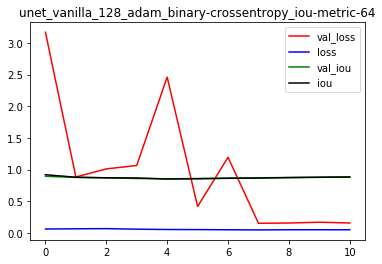

In [151]:
plot_progress()

In [0]:
import pickle

with open('/content/gdrive/My Drive/TGS-Salt-Segmentation/models/history/'+model_name+'.hist', 'wb') as history_file:
  pickle.dump(model_progress.history, history_file)

In [0]:
!pwd

/content/gdrive/My Drive/TGS-Salt-Segmentation


In [0]:
cd '/content/gdrive/My Drive/TGS-Salt-Segmentation'

/content/gdrive/My Drive/TGS-Salt-Segmentation


In [0]:
!git config --global user.email 'coltrobi@gmail.com'
!git config --global user.name 'Robert Colt'
!git remote add origin https://github.com/robiColt/TGS-Salt-Segmentation.git


fatal: remote origin already exists.


In [0]:
!git diff origin/master

In [0]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	models/trained/unet_vgg16_128_adam_binary-crossentropy_iou-metric.h5

nothing added to commit but untracked files present (use "git add" to track)


In [0]:
!git add .
!git commit -m 'trained unet vanilla model with iou metric'

[master 105ed1b] trained unet vanilla model with iou metric
 5 files changed, 2 insertions(+), 2 deletions(-)
 create mode 100644 models/history/unet_vanilla_128_adam_binary-crossentropy_iou-metric.png
 create mode 100644 models/history/unetvanill128.hist
 create mode 100644 models/trained/unet_vanilla_128_adam_binary-crossentropy_iou-metric.h5
 rewrite scripts/model_train.ipynb (97%)


In [0]:
!git pull

remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 16 (delta 7), reused 16 (delta 7), pack-reused 0
Unpacking objects: 100% (16/16), done.
From https://github.com/robiColt/TGS-Salt-Segmentation
   10efcfb..6c350bb  master     -> origin/master
Updating 10efcfb..6c350bb
Fast-forward
 .gitignore                                         |    4 +-
 scripts/__pycache__/loss_functions.cpython-36.pyc  |  Bin 1940 -> 2251 bytes
 .../__pycache__/loss_functions.cpython-36.pyc.orig |  Bin 0 -> 2250 bytes
 scripts/loss_functions.py                          |    9 +
 scripts/model_testing.ipynb                        |  331 +++++-
 scripts/model_testing_BACKUP_1908.ipynb            |  332 ++++++
 scripts/model_testing_BASE_1908.ipynb              | 1178 ++++++++++++++++++++
 scripts/model_testing_LOCAL_1908.ipynb             |  328 ++++++
 scripts/model_testing_REMOTE_1908.ipynb            |    1 +
 9 files

In [0]:
!git commit -m 'merged commit'

[master 10efcfb] merged commit


In [0]:
!git push

Counting objects: 39, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (39/39), done.
Writing objects: 100% (39/39), 5.13 MiB | 2.88 MiB/s, done.
Total 39 (delta 19), reused 0 (delta 0)
remote: Resolving deltas: 100% (19/19), completed with 3 local objects.
To https://github.com/robiColt/TGS-Salt-Segmentation.git
   d679adc..10efcfb  master -> master
